In [1]:
%reload_ext nb_black

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

<IPython.core.display.Javascript object>

In [3]:
k = 2
labels = KMeans(n_clusters=k).fit_predict(X_std)
print(metrics.silhouette_score(X_std, labels, metric="euclidean"))

0.5817500491982808


<IPython.core.display.Javascript object>

This sillhouette score is higher than the 3 cluster solution, even though there are 3 actual clusters. This is because 1 class is linearly seperable from the others. With two class, b<sub>i</sub>, the distance between the next nearest cluster, is larger than in the 3 cluster solution, since two of the true classes are very close together. b<sub>i</sub> should be the higher of the two measures for both solutions. So as b<sub>i</sub> gets bigger, the sillhouette solution gets higher.

### Heart Disease Set

In [4]:
postgres_user = "dsbc_student"
postgres_pw = "7*.8G9QH21"
postgres_host = "142.93.121.174"
postgres_port = "5432"
postgres_db = "heartdisease"

engine = create_engine(
    "postgresql://{}:{}@{}:{}/{}".format(
        postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db
    )
)

heart_df = pd.read_sql_query("select * from heartdisease", con=engine)

engine.dispose()


<IPython.core.display.Javascript object>

In [5]:
heart_df = heart_df.drop(index=0, axis=0)
# Define the features and the outcome
X = heart_df.iloc[:, :13]
y = heart_df.iloc[:, 13]

# Replace missing values (marked by `?`) with a `0`
X = X.replace(to_replace="?", value=0)

# Binarize `y` so that `1` means heart disease diagnosis and `0` means no diagnosis
y = np.where(y > 0, 0, 1)

<IPython.core.display.Javascript object>

In [6]:
heart_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
5,56.0,1.0,2.0,120.0,236.0,0.0,0.0,178.0,0.0,0.8,1.0,0.0,3.0,0


<IPython.core.display.Javascript object>

1. Split the data randomly into two. Apply k-means using two, three, and four as the number of clusters, as you did when you were exploring consistency earlier in this checkpoint. Assess the consistency of the solutions using visualization. Which one seems to be the best?

In [7]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

<IPython.core.display.Javascript object>

In [8]:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(X_std, X_pca, test_size=0.5)

<IPython.core.display.Javascript object>

In [9]:
len(X)
len(X_pca)

302

<IPython.core.display.Javascript object>

In [10]:
# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([(X_half1, X_pcahalf1), (X_half2, X_pcahalf2)]):
    #     print(data[1])
    #     break
    # Put the features into ypred.
    ypred["pca_f1" + "_sample" + str(counter)] = data[1][:, 0]
    ypred["pca_f2" + "_sample" + str(counter)] = data[1][:, 1]

    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust).fit_predict(data[counter])
        ypred["clust" + str(nclust) + "_sample" + str(counter)] = pred

<IPython.core.display.Javascript object>

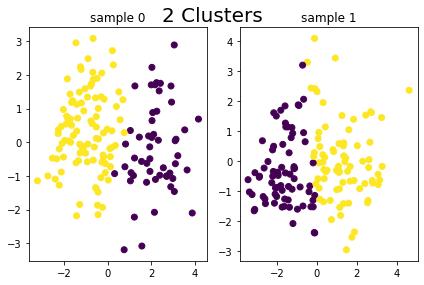

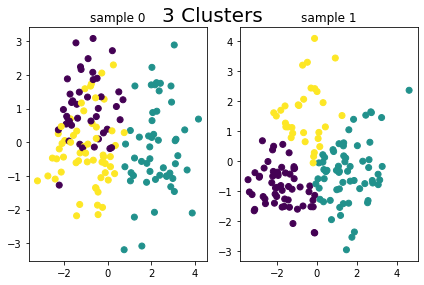

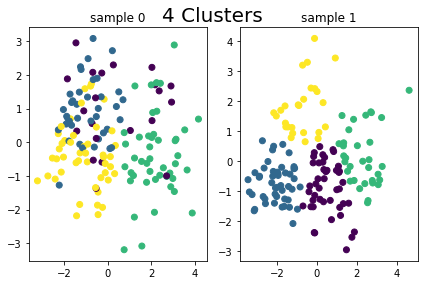

<IPython.core.display.Javascript object>

In [11]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):

    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)

    # Make a plot for each sample.
    for i in range(2):

        # PCA-created features.
        x_sub = ypred["pca_f1_sample{}".format(i)]
        y_sub = ypred["pca_f2_sample{}".format(i)]

        # Cluster assignments.
        c = ypred["clust{}_sample{}".format(cluster, i)]

        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title("sample {}".format(i))

    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle("{} Clusters".format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print("\n")

2. Apply k-means on the whole dataset by setting k equal to 2, 3, and 4. Get the ARI score for each of them. Which model is best?

In [12]:
full_pred = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
full_pred = np.array([0 if x == 1 else 1 if x == 0 else 2 for x in full_pred])

metrics.adjusted_rand_score(y, full_pred)

0.2870229567629351

<IPython.core.display.Javascript object>

In [13]:
for n in range(2, 5):
    full_pred = KMeans(n_clusters=n).fit_predict(X_std)
    full_pred = np.array([0 if x == 1 else 1 if x == 0 else 2 for x in full_pred])

    print(
        "ARI for {} clusters is {}".format(n, metrics.adjusted_rand_score(y, full_pred))
    )

ARI for 2 clusters is 0.44545609632673205
ARI for 3 clusters is 0.287255517548566
ARI for 4 clusters is 0.06547289216309767


<IPython.core.display.Javascript object>

In [14]:
for n in range(2, 5):
    full_pred = KMeans(n_clusters=n).fit_predict(X_std)
    full_pred = np.array([0 if x == 1 else 1 if x == 0 else 2 for x in full_pred])

    print(
        "Sillhouette Coef for {} clusters is {}".format(
            n, metrics.silhouette_score(X_std, full_pred, metric="euclidean")
        )
    )

Sillhouette Coef for 2 clusters is 0.17617692225171439
Sillhouette Coef for 3 clusters is 0.13075476754316953
Sillhouette Coef for 4 clusters is 0.17244720252704163


<IPython.core.display.Javascript object>